# Model training

In [76]:
import numpy as np
import pandas as pd
import os

In [77]:
DATA_SUBDIR = '../data'

##### Importing the data

Here I'll be using the data exported in `data_analysis.ypynb`

In [78]:
data = pd.read_pickle(os.path.join(DATA_SUBDIR, 'train.pkl'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371848 entries, 388024 to 451283
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   altura                  371848 non-null  int64  
 1   exposicion              371848 non-null  int64  
 2   inclinacion_suelo       371848 non-null  int64  
 3   distancia_agua          371848 non-null  int64  
 4   altura_agua             371848 non-null  int64  
 5   distancia_caminos       371848 non-null  int64  
 6   sombra_maniana          371848 non-null  int64  
 7   sombra_mediodia         371848 non-null  int64  
 8   sombra_tarde            371848 non-null  int64  
 9   distancia_fuego         371848 non-null  int64  
 10  clase_suelo             371848 non-null  int64  
 11  dosel_forestal          371848 non-null  int64  
 12  sombra                  371848 non-null  float64
 13  clase_area_silvestre_1  371848 non-null  uint8  
 14  clase_area_silv

In [79]:
data.head()

,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_suelo,dosel_forestal,sombra,clase_area_silvestre_1,clase_area_silvestre_2,clase_area_silvestre_3,clase_area_silvestre_4,clase_suelo_10,clase_suelo_39,clase_suelo_38
388024,3372,91,13,603,215,1401,240,219,108,1022,39,7,189.000000,0,0,1,0,0,1,0
254008,2521,42,7,124,13,882,221,225,139,934,6,2,195.000000,0,0,0,1,0,0,0
349506,3197,92,8,85,6,390,233,228,128,1920,22,1,196.333333,1,0,0,0,0,0,0
19002,2803,34,12,90,11,4142,218,213,129,5407,29,1,186.666667,1,0,0,0,0,0,0
456137,2596,247,22,242,133,1500,169,250,214,1342,3,3,211.000000,0,0,1,0,0,0,0


Let's manipulate the data a little more and scale the numerical features

In [80]:
from sklearn.preprocessing import StandardScaler

# Separete the target
target = data['dosel_forestal']
data.drop(['dosel_forestal'], axis=1, inplace=True)

# Separate the categorical features
cat_features = [
	'clase_area_silvestre_1',
	'clase_area_silvestre_2',
	'clase_area_silvestre_3',
	'clase_area_silvestre_4',
	'clase_suelo_10',
	'clase_suelo_39',
	'clase_suelo_38'
	]

num_data = data.drop(cat_features, axis=1)
cat_data = data[cat_features]

# Scale numerical features
scaler = StandardScaler()
scaled_num_data = scaler.fit_transform(num_data)

Combine all the data

In [81]:
prep_data = np.concatenate([scaled_num_data, cat_data.to_numpy()], axis=1)

## Random Forest

Now let us try training a random forest model with the prepared data

In [82]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=10, random_state=1234)
rf_classifier.fit(prep_data, target)
rf_prediction = rf_classifier.predict(prep_data)

Let's compare the prediction with the original data in graphs 

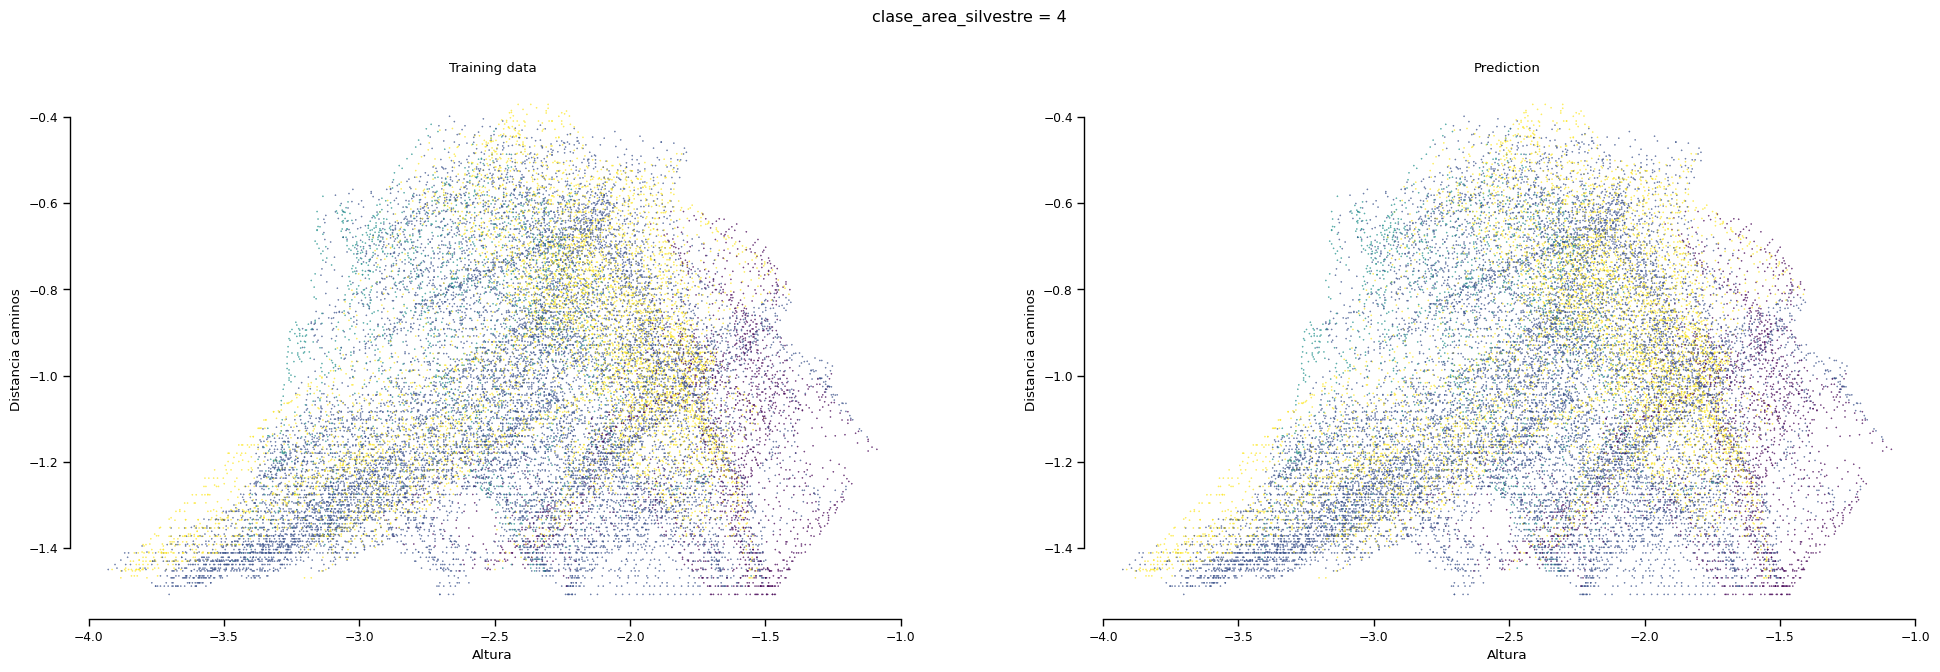

In [73]:
from matplotlib import pyplot as plt
import seaborn as sns

# Columns are
# ===========
# altura	exposicion	inclinacion_suelo	distancia_agua	altura_agua	distancia_caminos	sombra_maniana	sombra_mediodia	sombra_tarde	distancia_fuego	clase_suelo	sombra	clase_area_silvestre_1	clase_area_silvestre_2	clase_area_silvestre_3	clase_area_silvestre_4	clase_suelo_10	clase_suelo_39	clase_suelo_38

idx_altura = 0; idx_inclinacion_suelo = 2; idx_distancia_caminos = 5; idx_sombra = 11; idx_clase_area_silvestre_4 = 15;

fig = plt.figure(figsize=(24, 7))
fig.suptitle("clase_area_silvestre = 4")
sns.set_context("paper")

mask = prep_data.T[idx_clase_area_silvestre_4].astype('bool')

ax = fig.add_subplot(121, title="Training data")
ax.scatter(prep_data.T[idx_altura][mask], prep_data.T[idx_distancia_caminos][mask], c=target[mask], s=0.1)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

ax = fig.add_subplot(122, title="Prediction")
ax.scatter(prep_data.T[idx_altura][mask], prep_data.T[idx_distancia_caminos][mask], c=rf_prediction[mask], s=0.1)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

sns.despine(trim=True)

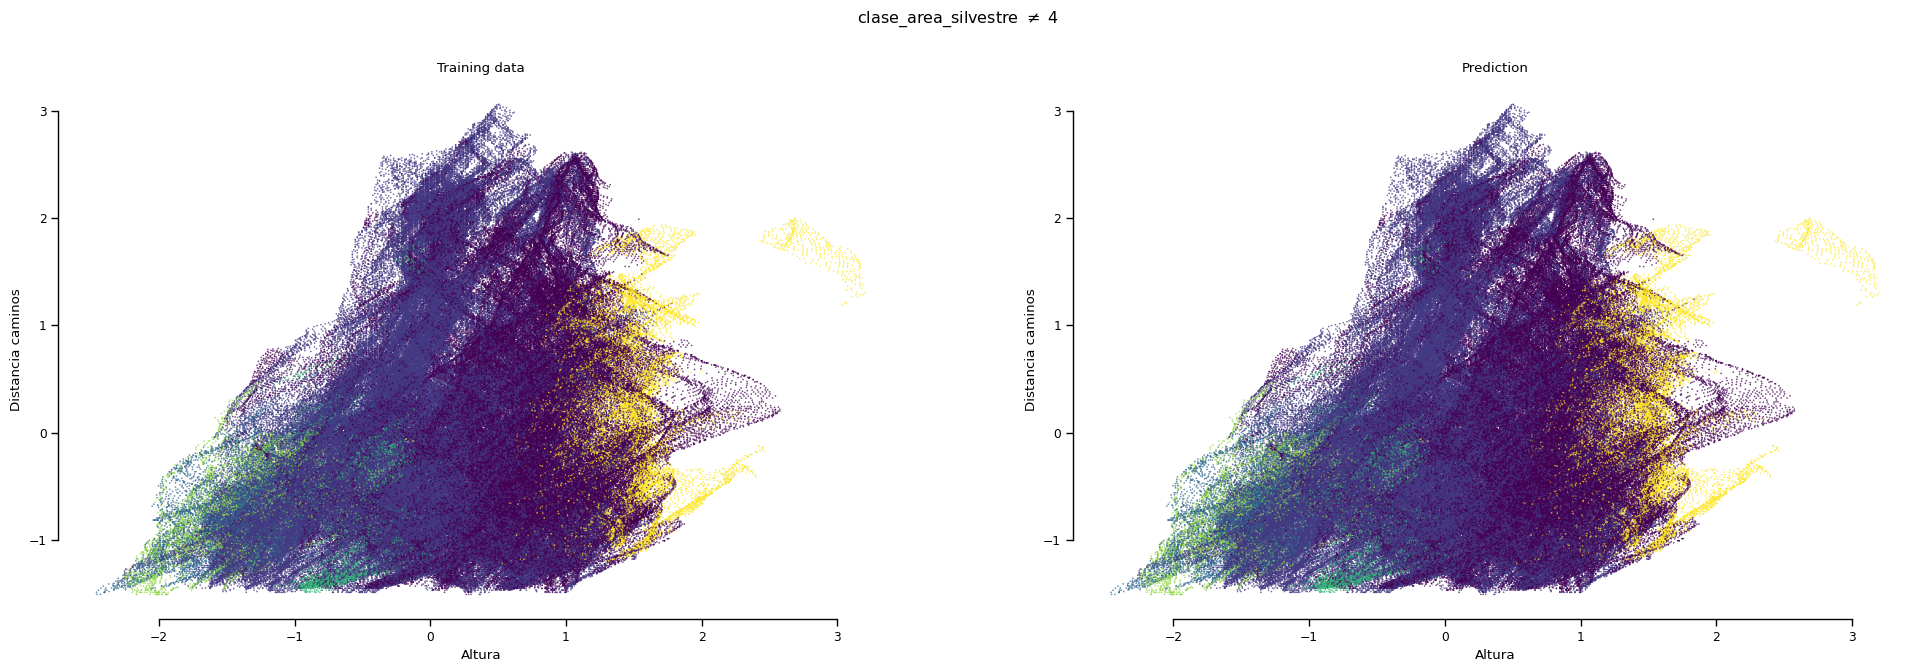

In [74]:
idx_altura = 0; idx_inclinacion_suelo = 2; idx_distancia_caminos = 5; idx_sombra = 11; idx_clase_area_silvestre_4 = 15;


fig = plt.figure(figsize=(24, 7))
fig.suptitle("clase_area_silvestre $\\neq$ 4")
sns.set_context("paper")

mask = np.logical_not(prep_data.T[idx_clase_area_silvestre_4].astype('bool'))

ax = fig.add_subplot(121, title="Training data")
ax.scatter(prep_data.T[idx_altura][mask], prep_data.T[idx_distancia_caminos][mask], c=target[mask], s=0.1)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

ax = fig.add_subplot(122, title="Prediction")
ax.scatter(prep_data.T[idx_altura][mask], prep_data.T[idx_distancia_caminos][mask], c=rf_prediction[mask], s=0.1)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

sns.despine(trim=True)

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(rf_prediction, target))
mae = mean_absolute_error(rf_prediction, target)

print(f'RMSE:\t{rmse:.6f}\nMAE:\t{mae:.6f}')

RMSE:	0.112832
MAE:	0.004088


In [86]:
importances = rf_classifier.feature_importances_
features = data.columns

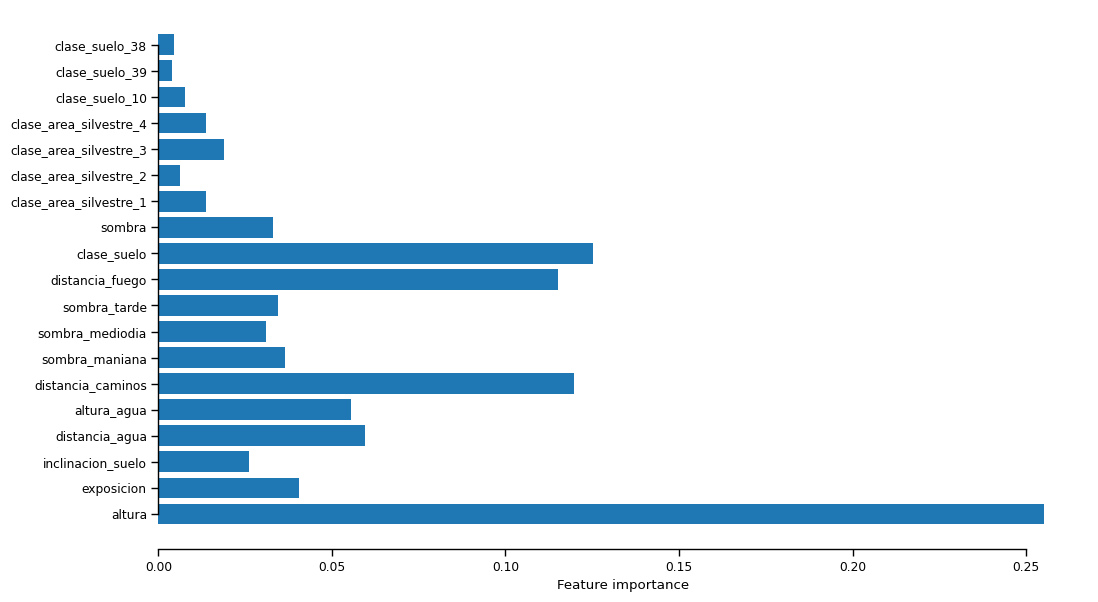

In [94]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_context('paper')

ax.barh(features, importances)
ax.set_xlabel('Feature importance')
sns.despine(trim=True)